In [1]:
import sys
import os 

repo_root = os.path.abspath('..')
sys.path.append(repo_root)

from src.utils.database_manager import DatabaseManager
from src.models.boost import RentPricePredictor
from src.models.neural_network import NeuralNetworkRegressor
from src.models import tf_idf

import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
import numpy as np



2024-09-04 16:59:56.714301: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-04 16:59:56.715042: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-04 16:59:56.716962: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-04 16:59:56.722332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 16:59:56.730900: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

## ML WORKFLOW

- Prepare Data
    - Retrieve Unit Amenities 
    - TF-IDF
    - Retrieve Pricing and Other Information 
    - Merge 
    - One Hot Encoding
    - Standard Scaler 
- Dimension Reduction
- XG boost hyper paramter tuning
- Model Comparisons with final K fold results test


In [2]:

def retrieve_combined_dataset(city, state_abbr):
    db_manager = DatabaseManager('../apf.db')

    amenities_df = db_manager.retrieve_amenities(city, state_abbr)
    tf_idf_df = tf_idf.get_tf(amenities_df)
    unit_df = db_manager.retrieve_units(city, state_abbr)
    merged_df = pd.merge(tf_idf_df, unit_df, on='UnitId', how='left')
    merged_df['Neighborhood'].replace('', 'Unknown', inplace=True)

    return merged_df


def prepare_data(df):
    # Filter rows with non-null RentPrice values
    df = df[df['RentPrice'].notna()]
    
    # Define categorical and numeric columns
    categorical_columns = ['Neighborhood']  # Add more categorical columns if necessary
    numeric_columns = [col for col in df.columns if col not in ['UnitId', 'RentPrice', 'ModelName', 'Neighborhood']]
    
    # Convert categorical columns to strings
    df[categorical_columns] = df[categorical_columns].astype(str)
    
    # Ensure numeric columns are numeric and replace any non-numeric data with NaN or zeros if necessary
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # One-hot encoding for categorical data and scaling for numeric data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_columns),
            ('cat', OneHotEncoder(drop='first'), categorical_columns)
        ]
    )
    
    # Drop unnecessary columns and separate features and target
    X = df.drop(columns=['UnitId', 'RentPrice', 'ModelName']).fillna(0.0)
    y = df['RentPrice']
    
    # Apply preprocessing (scaling and one-hot encoding)
    scaled_X = preprocessor.fit_transform(X)
    
    return scaled_X, y



In [3]:
df = retrieve_combined_dataset('austin', 'tx')
print(df.head())

8
    UnitId        10  10ft   11   12  120  128   13   14   15  ...  your  \
0  000vnf3  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
1  001g8z2  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
2  001ypl3  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
3  0025j52  0.445509   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
4  0026113  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   

   RentPrice  Beds  Baths  SquareFootage               ModelName  Latitude  \
0     1350.0     1    1.0          729.0                      A3  30.42922   
1     2650.0     2    2.0         1157.0                      B4  30.25503   
2     1250.0     1    1.0          742.0  1 Bedroom One Bathroom  30.33204   
3     1479.0     1    1.0          762.0                     A12  30.47948   
4     2062.0     3    2.0         1367.0                      C1  30.21591   

   Longitude  NumUnits      Neighborhood  
0  -97.69659        45    Sco

/tmp/ipykernel_99061/969982385.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Neighborhood'].replace('', 'Unknown', inplace=True)


In [4]:
scaled_X, y = prepare_data(df)

/tmp/ipykernel_99061/969982385.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical_columns] = df[categorical_columns].astype(str)
/tmp/ipykernel_99061/969982385.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce').fillna(0)


## Dimension Reduction


find number of components using a scree graph

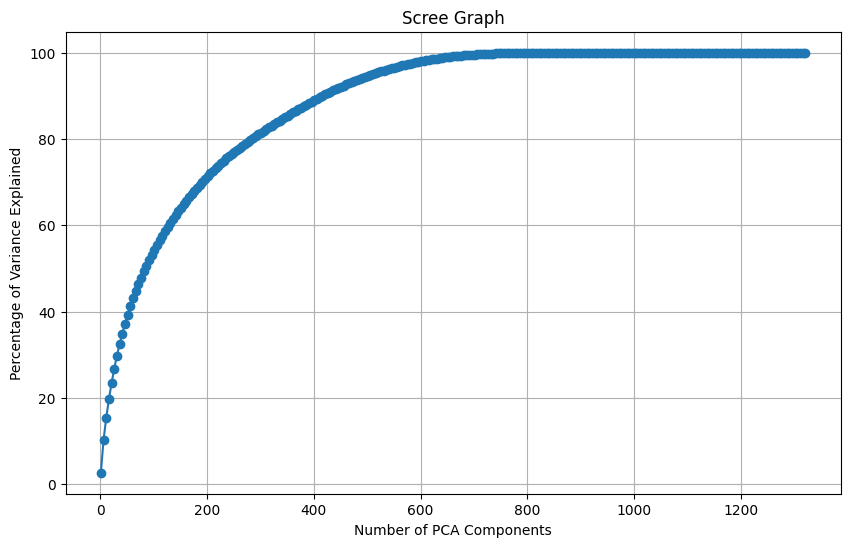

In [5]:

# Initialize PCA and fit the model to the scaled data
pca = PCA()
pca.fit(scaled_X)

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
components_tested = np.arange(1, len(cumulative_explained_variance) + 1, 5)
selected_variance = cumulative_explained_variance[components_tested - 1]

plt.figure(figsize=(10, 6))
plt.plot(components_tested, selected_variance * 100, marker='o')
plt.title("Scree Graph")
plt.xlabel("Number of PCA Components")
plt.ylabel("Percentage of Variance Explained")
plt.grid(True)
plt.show()


In [6]:
def dimension_reduction(df, n_components=50):
    pca = PCA(n_components=n_components)
    reduced_df = pca.fit_transform(df)
    return reduced_df

reduced_X = dimension_reduction(scaled_X, n_components=350)

## XG Boost hyper parameter tuning

In [7]:
boost = RentPricePredictor()
best_model, best_params, best_score = boost.tune_xgboost_hyperparameters(reduced_X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


##  K folds validation

In [17]:


# Repeated K-Fold cross-validator
repeated_kf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# Initialize the XGBoost model and lists for storing results
xgboost_model = boost.get_model(best_params)
xgboost_mse_scores = []
xgboost_predictions = []

# Initialize the Neural Network and lists for storing results
neural_network_model = NeuralNetworkRegressor()
nn_mse_scores = []
nn_predictions = []

# Store true values for all test sets
all_test_targets = []

# Loop over each split in the repeated K-Fold
for train_indices, test_indices in repeated_kf.split(reduced_X):
    
    X_train, X_test = reduced_X[train_indices], reduced_X[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    
    all_test_targets.extend(y_test)

    # XGBoost model training and evaluation
    trained_xgboost_model = boost.train_model(xgboost_model, X_train, y_train)
    xgboost_pred = trained_xgboost_model.predict(X_test)
    xgboost_predictions.extend(xgboost_pred)
    xgboost_mse = boost.evaluate_model(trained_xgboost_model, X_test, y_test)
    xgboost_mse_scores.append(xgboost_mse)

    # Neural Network model training and evaluation
    trained_nn_model = neural_network_model.train_model(X_train, y_train)
    nn_pred = trained_nn_model.predict(X_test)
    nn_predictions.extend(nn_pred)
    nn_mse = neural_network_model.evaluate_model(trained_nn_model, X_test, y_test)
    nn_mse_scores.append(nn_mse)

# Calculate and print average MSE across folds
average_xgboost_mse = sum(xgboost_mse_scores) / len(xgboost_mse_scores)
average_nn_mse = sum(nn_mse_scores) / len(nn_mse_scores)

print(f"Average XGBoost MSE: {average_xgboost_mse}")
print(f"Average Neural Network MSE: {average_nn_mse}")




/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1725486309.800813   99061 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-04 17:45:09.801957: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step


/home/jackyeung99/apartment_finder/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
Average XGBoost MSE: 52302.33786854243
Average Neural Network MSE: 231536.265


Plotting

In [38]:
def plot_mse_distribution(ax, mse_scores):
    ax.hist(mse_scores)
    ax.set_title("Mean Squared Error Across Folds")
    ax.set_xlabel("Distribution of Folds")
    ax.set_ylabel("MSE")

# Function for Actual vs Predicted Scatter Plot
def plot_actual_vs_predicted(ax, y_test, y_pred):
    ax.scatter(y_test, y_pred, alpha=0.5)
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    ax.set_xlabel("Actual Rent Price")
    ax.set_ylabel("Predicted Rent Price")
    ax.set_title("Actual vs Predicted Rent Prices")




XG BOOST Results

XG BOOST Average MSE: 52302.33786854243


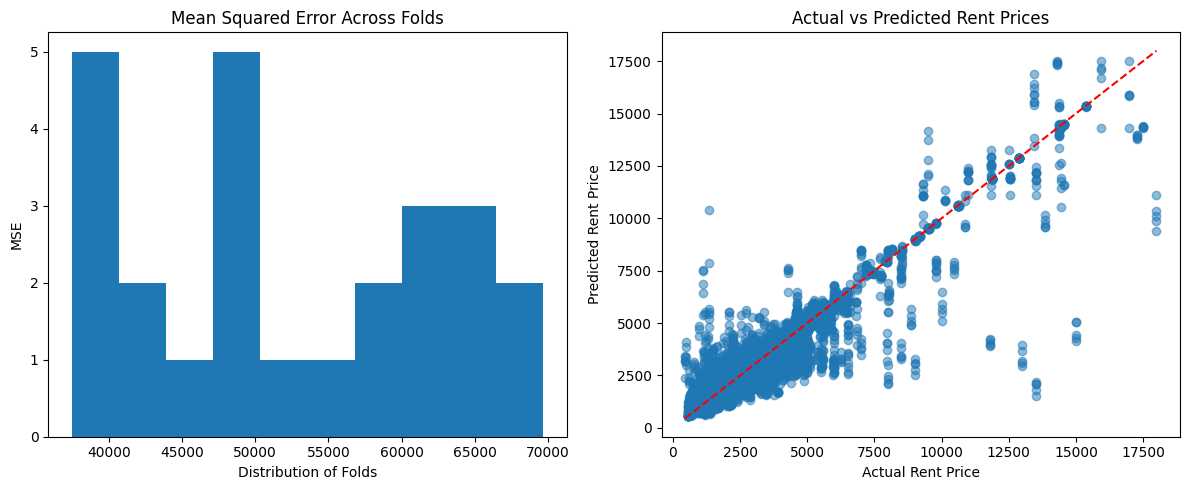

In [42]:
print(f"XG BOOST Average MSE: {average_xgboost_mse}")
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plot_mse_distribution(ax[0], xgboost_mse_scores)
plot_actual_vs_predicted(ax[1], all_test_targets, xgboost_predictions)


plt.tight_layout()
plt.show()


Neural Network Results 

Neural Network Average MSE: 231536.265


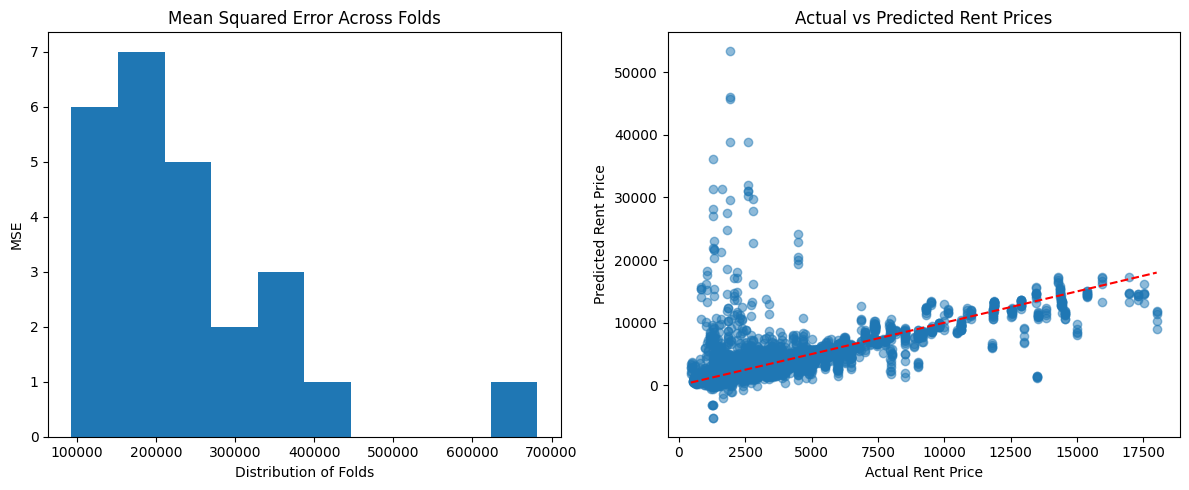

In [43]:
print(f"Neural Network Average MSE: {average_nn_mse}")
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plot_mse_distribution(ax[0], nn_mse_scores)
plot_actual_vs_predicted(ax[1], all_test_targets, nn_predictions)


plt.tight_layout()
plt.show()